Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB10
Use reinforcement learning to devise a tic-tac-toe player.

## Deadlines:
Submission: Dies Natalis Solis Invicti
Reviews: Befana
Notes:



In [16]:
import numpy as np
from itertools import combinations
from collections import namedtuple, defaultdict
from random import choice
from copy import deepcopy
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import random


In [17]:
State = namedtuple('State', ['x', 'o'])

In [18]:
MAGIC = [2, 7, 6, 9, 5, 1, 4, 3, 8]

# Prioritized Experience Replay (PER) - class Memory implemented

In [19]:
class Memory:
    def __init__(self, capacity, alpha=0.5):
        self.capacity = capacity
        self.memory = []
        self.alpha = alpha

    def add(self, experience):
        state, action, reward, next_state, done, td_error = experience
        priority = abs(td_error) ** self.alpha
        self.memory.append((state, action, reward, next_state, done, priority))

    def sample(self, batch_size):
        priorities = np.array([priority for _, _, _, _, _, priority in self.memory])
        priorities /= np.sum(priorities)
        indexes = np.random.choice(len(self.memory), batch_size, p=priorities)
        return [self.memory[i] for i in indexes]


In [20]:
def print_board(pos):
    """Nicely prints the board"""
    for r in range(3):
        for c in range(3):
            i = r * 3 + c
            if MAGIC[i] in pos.x:
                print('X', end='')
            elif MAGIC[i] in pos.o:
                print('O', end='')
            else:
                print('.', end='')
        print()
    print()

In [21]:
def win(elements):
    """Checks is elements is winning"""
    #print("state evaluation. Elements: ",elements)
    return any(sum(c) == 15 for c in combinations(elements, 3))

'''A reward is calculated for each state of each game.
The reward is calculated as the evaluation of the final state of the game.
In this case, the evaluation is done by the state_value() function, which returns a value between -1 and 1.'''

def state_value(pos: State):
    """Evaluate state: +1 first player wins"""

    if win(pos.x):
        #print_board(State)
        return -10
    elif win(pos.o):
        #print_board(State)
        return 100
    else:
        return -5



In [22]:
#useful to convert from the State conventiion to a 1-D grid (useful for debugging or gray_code)
def state_to_matrix(state):
  matrix = np.empty((9,1),dtype=str)
  for i,_ in enumerate(matrix) : matrix[i] = "."

  for i in state.x:
    matrix[i-1] = "X"

  for i in state.o:
    matrix[i-1,0] = "O"

  return matrix


def gray_code(state):
  """
  Converts the tic tac toe matrix to a trinary number using Gray's encoding algorithm.
  It's usefull to convert a state on the game grid into a index number for the Q-table

  Args:
    state: actua tic tac toe grid situation.

  Returns:
    Converted trinary number
  """
  matrix = state_to_matrix(state)
  # print(matrix)
  numbers = []
  for symbol in matrix:
    if symbol == "X":
      numbers.append(1)
    elif symbol == "O":
      numbers.append(0)
    else:
      numbers.append(2)

  binary_number = "".join(str(n) for n in numbers)
  return int(binary_number, 3)

# matrix = ["O", "O", "O", "O", "O", "O", "O", "X", "."]
# state = State(set(), set())
# state.x.add(1)
# state.x.add(5)
# state.o.add(4)

# index = gray_code(state)

# print(index)

In [23]:


#define the shape of the environment (i.e., its states)
num_states = pow(3,9)  #each state is a configuration of the table -> on each position can be drawn a X,O or . so we have 3^9 possible states
num_actions = 9 # O on one of the 9 positions

#Create a 3D numpy array to hold the current Q-values for each state and action pair: Q(s, a)
#The array contains 11 rows and 11 columns (to match the shape of the environment), as well as a third "action" dimension.
#The "action" dimension consists of 4 layers that will allow us to keep track of the Q-values for each possible action in
#each state (see next cell for a description of possible actions).
#The value of each (state, action) pair is initialized to 0.
q_table = np.zeros((num_states, num_actions))

#put all of them equal to -1 to find the shortest solution ???
#for id,_ in enumerate(q_table): q_table[id] = -1




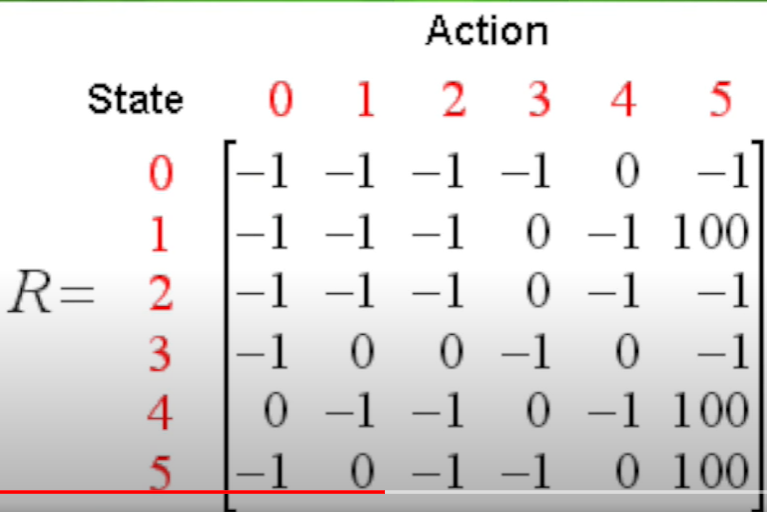

In [24]:
# #the actions are represented by the possible positions in the grid
actions = set(range(1, 9+1))
# q_table = np.zeros((num_states, num_actions))
# #put all of them equal to -1 to find the shortest solution ???
# for id,_ in enumerate(q_table): q_table[id] = -1

# q_table[1,2] = 10


def get_next_action(state,available, epsilon):
  #if a randomly chosen value between 0 and 1 is less than epsilon,
  #then choose the most promising value from the Q-table for this state.   - EXPLOITATION
  if np.random.random() < epsilon:
      #if the best one is not available, choose the next best available one
        q_values = q_table[state]
        #sort the actions according to their corresponding Q values
        sorted_actions = [x for _, x in sorted(zip(q_values, actions), reverse=True)]
        for action in sorted_actions:
            if action in available:
                return action

  else: #choose a random action     - EXPLORATION
    next_action = choice(list(available))
    return next_action

def extract_action(old_state, state):
    x_action = state.x - old_state.x
    o_action = state.o - old_state.o
    if x_action:
        return ('x', x_action.pop())
    elif o_action:
        return ('o', o_action.pop())
    else:
        return None

In [25]:
def random_game():
    trajectory = list()
    state = State(set(), set())
    available = set(range(1, 9+1))
    while available:
        x = choice(list(available))
        state.x.add(x)
        trajectory.append(deepcopy(state))
        available.remove(x)
        if win(state.x) or not available:
            print("x vince")
            break

        o = choice(list(available))
        state.o.add(o)
        trajectory.append(deepcopy(state))
        available.remove(o)
        if win(state.o):
            break
    return trajectory

# memory definition for the Prioritized Experience Replay (PER) approach implementation

In [26]:
memory = Memory(100000)
batch_size = 128

#Episodical approach -> add an update based on previous knowledge
def update_with_memory(memory, q_table, discount_factor, lr):
    # Estrai un minibatch di esperienze dalla memoria
    minibatch = memory.sample(batch_size)

    # Calcola i valori target per ogni esperienza
    for experience in minibatch:
        state, action, reward, next_state, done, td_error = experience

        # Calcola il valore target
        target = reward + discount_factor * np.max(q_table[next_state])

        # Aggiorna la Q-table
        q_table[state][action-1] = (1 - lr) * q_table[state][action-1] + lr * target

    return q_table



# This function introduces the agent policy

In [27]:
def my_player(q_table,state,available,trajectory,eps,discount_factor,lr):
#calculate the CURRENT state index for the direct access to the q_table
        #print(f"old state: {state}")
        old_state_index = gray_code(state)
        #print(f"old state index: {old_state_index}")
        #print(old_state_index)

        #take the best action according to the current state
        action = get_next_action(old_state_index,available,eps)
        #print(f"action: {action}")

        #new state
        state.o.add(action)
        #print(f"new state: {state}")

        #reward after the action
        reward = state_value(state)
        #print(f"reward: {reward}")

        #calculate the NEW state index for the direct access to the q_table
        new_state_index = gray_code(state)
        #print(f"new_state_index: {new_state_index}")

        td_error = reward + discount_factor * np.max(q_table[new_state_index]) - q_table[old_state_index][action-1]

        #print(new_state_index)
        #compute the REWARD according to the NEW state

        #add Episodical Q-learning stuff
        experience = (old_state_index, action, reward, new_state_index, available,td_error)
        memory.add(experience)

        #update the q_table using the Bellman function
        q_table[old_state_index][action-1] =  (1-lr)*np.max(q_table[new_state_index]) + lr*(reward + discount_factor *  np.max(q_table[new_state_index]))
        #print(f"q value after updating: {q_table[old_state_index][action-1]}")
        #print("   \n")

        #add an update based on Episodical Q-learning approach
        if len(memory.memory) >= batch_size:
            q_table = update_with_memory(memory, q_table, discount_factor, lr)

        trajectory.append(deepcopy(state))
        #actions_hist.append(action)
        available.remove(action)

        if win(state.o):
            #print("o wins")
            trajectory.append(deepcopy(state))
            return old_state_index,action,True

        #print(f"\nTurn {turno}")


        return old_state_index,action,False


# Play a game - this is the version used for the TRAINING PHASE
## a  Prioritized Experience Replay (PER) version of Q- Learning has been adopted


In [28]:
reward = -1

# Q-LEARNING with EPISODICAL MEMORY

def play_game(q_table,eps,discount_factor,lr,first="my_player"):
    trajectory = list()
    actions_hist = list()
    state = State(set(), set())
    available = set(range(1, 9+1))
    tot_reward = 0
    turno = 0
    old_state_index = None
    action  = None

    while available:
      turno +=1
      end = False

    ####### now let your agent play its turn
      if first == "my_player":
          #calculate the CURRENT state index for the direct access to the q_table
          old_state_index,action,won = my_player(q_table,state,available,trajectory,eps,discount_factor,lr)

          if won or not available:
            #print("pareggio")
            #trajectory.append(deepcopy(state))
            return trajectory


          ####### x plays a random game ########

          x = choice(list(available))
          state.x.add(x)
          trajectory.append(deepcopy(state))
          available.remove(x)

          if win(state.x):
              #if the opponent wins, then update the q-table of our agent penalizing the last state-action pair
              q_table[old_state_index][action-1] -= 100
              return trajectory

      else:
        ####### x plays a random game ########

        x = choice(list(available))
        state.x.add(x)
        trajectory.append(deepcopy(state))
        available.remove(x)

        if win(state.x):
            #if the opponent wins, then update the q-table of our agent penalizing the last state-action pair
            q_table[old_state_index][action-1] -= 100
            return trajectory

        if not available:
          q_table[old_state_index][action-1] -= 10
          return trajectory

        #####my_player turn

        old_state_index,action,won = my_player(q_table,state,available,trajectory,eps,discount_factor,lr)

        if won == True:
          return trajectory




    return trajectory




# This version below is just used by the already trained model to test the performances:
Accuracy has been used as metric
- up to 95% if the my_Agent starts the game (on 100 matches)
- up to 70% is the oppositor starts the game (on 100 matches)
- up to 85% for randomic order (on 100 matches)

In [29]:
reward = -1

def my_player_no_train(q_table,state,available,trajectory,eps,discount_factor,lr):
#calculate the CURRENT state index for the direct access to the q_table
        #print(f"old state: {state}")
        old_state_index = gray_code(state)
        #print(f"old state index: {old_state_index}")
        #print(old_state_index)

        #take the best action according to the current state
        action = get_next_action(old_state_index,available,eps)
        #print(f"action: {action}")

        #new state
        state.o.add(action)
        #print(f"new state: {state}")

        #reward after the action
        reward = state_value(state)
        #print(f"reward: {reward}")

        #calculate the NEW state index for the direct access to the q_table
        new_state_index = gray_code(state)
        #print(f"new_state_index: {new_state_index}")

        #td_error = reward + discount_factor * np.max(q_table[new_state_index]) - q_table[old_state_index][action-1]

        #print(new_state_index)
        #compute the REWARD according to the NEW state

        #add Episodical Q-learning stuff
        #experience = (old_state_index, action, reward, new_state_index, available,td_error)
        #memory.add(experience)

        #update the q_table using the Bellman function
        #q_table[old_state_index][action-1] =  (1-lr)*np.max(q_table[new_state_index]) + lr*(reward + discount_factor *  np.max(q_table[new_state_index]))
        #print(f"q value after updating: {q_table[old_state_index][action-1]}")
        #print("   \n")

        #add an update based on Episodical Q-learning approach
        #if len(memory.memory) >= batch_size:
            #q_table = update_with_memory(memory, q_table, discount_factor, lr)

        trajectory.append(deepcopy(state))
        #actions_hist.append(action)
        available.remove(action)

        if win(state.o):
            #print("o wins")
            trajectory.append(deepcopy(state))
            return old_state_index,action,True

        #print(f"\nTurn {turno}")


        return old_state_index,action,False

# Q-LEARNING with EPISODICAL MEMORY

def play_game_no_train(q_table,eps,discount_factor,lr,first="my_player"):
    trajectory = list()
    actions_hist = list()
    state = State(set(), set())
    available = set(range(1, 9+1))
    tot_reward = 0
    turno = 0
    old_state_index = None
    action  = None

    while available:
      turno +=1
      end = False

    ####### now let your agent play its turn
      if first == "my_player":
          #calculate the CURRENT state index for the direct access to the q_table
          old_state_index,action,won = my_player_no_train(q_table,state,available,trajectory,eps,discount_factor,lr)

          if won or not available:
            #print("pareggio")
            #trajectory.append(deepcopy(state))
            return trajectory


          ####### x plays a random game ########

          x = choice(list(available))
          state.x.add(x)
          trajectory.append(deepcopy(state))
          available.remove(x)

          if win(state.x):
              #if the opponent wins, then update the q-table of our agent penalizing the last state-action pair
              q_table[old_state_index][action-1] -= 100
              return trajectory

      else:
        ####### x plays a random game ########

        x = choice(list(available))
        state.x.add(x)
        trajectory.append(deepcopy(state))
        available.remove(x)

        if win(state.x):
            #if the opponent wins, then update the q-table of our agent penalizing the last state-action pair
            q_table[old_state_index][action-1] -= 100
            return trajectory

        if not available:
          q_table[old_state_index][action-1] -= 10
          return trajectory

        #####my_player turn

        old_state_index,action,won = my_player_no_train(q_table,state,available,trajectory,eps,discount_factor,lr)

        if won == True:
          return trajectory




    return trajectory




# FIND THE BEST CONFIG FOR YOUR FINAL TRAINING - validation test


In [30]:
#define training parameters
 #the percentage of time when we should take the best action (instead of a random action)
dfs = [0.00001,0.0001,0.001,0.01,0.1] #discount factor for future rewards
lrs= [0.00001,0.0001,0.001,0.01,0.1] #the rate at which the AI agent should learn
epss = [0.1,0.3,0.5,0.7,0.9]
history = list()
"Best e: 0.9, best_df: 0.0001, best_lr: 0.1"

best_acc = None
best_e = None
best_df = None
best_lr = None

max_iter = 10_000


for df in dfs:
 for lr in lrs:
  for eps in epss:

    q_table = np.zeros((num_states, num_actions))
    # #put all of them equal to -1 to find the shortest solution ???
    # for id,_ in enumerate(q_table): q_table[id] = -1

    o_wins = 0
    iter= 0

    for _ in tqdm(range(max_iter)):
      trajectory = play_game(q_table,eps,df,lr)
      final_reward = state_value(trajectory[-1])
      if final_reward == 100:
        o_wins+=1
        history.append((iter,1))
      else:
        history.append((iter,0))
      iter+=1

    #let them play - 1000 iter for each config to test the systems
    o_wins = 0
    for _ in tqdm(range(1000)):
      trajectory = play_game(q_table,eps,df,lr)
      final_reward = state_value(trajectory[-1])
      #print(trajectory)
      if final_reward == 100:
        o_wins+=1


    acc = o_wins/1000
    print(f"Accuracy: {acc}, eps: {eps}, df: {df}, lr: {lr} ")

    if best_acc == None or acc > best_acc:
      best_acc = acc
      best_e = eps
      best_df = df
      best_lr = lr

print(f"Best e: {best_e}, best_df: {best_df}, best_lr: {best_lr}")
# history = np.array(history)
# plt.figure(figsize=(14, 4))
# plt.plot(history[:, 0], history[:, 1], marker=".")


# TRAIN WITH THE BEST CONFIGURATION


In [ ]:
''' Best e: 0.9, best_df: 0.001, best_lr: 0.0001 in theory but pratically best_lr = 0.1 or 0.01'''

# I introduced a change in epsilon to favor exploration instead of exploitation when a plateau in accuracy occurs
# the value is incremented again when the situation come back stabler

df = 0.01
lr = 0.01
eps_original = 0.9
eps = 0.9   #low at first to favor the exploration but then it grows to promote exploitation
max_iter = 25_000
history = list()
last_accuracies = []
flat_threshold = 0.01
turns_since_eps_change = 0
eps_change = False
buffer_size = 3000
rest_period = 3000
best_eps = 1
best_acc = 0  # Migliore accuratezza raggiunta
best_q_table = None  # Migliore configurazione del modello
acc_drop_threshold = 0.15  # Percentuale di calo dell'accuratezza che triggera il ripristino

q_table = np.zeros((num_states, num_actions))
  # #put all of them equal to -1 to find the shortest solution ???
  # for id,_ in enumerate(q_table): q_table[id] = -1

o_wins = 0
iter= 0
acc = 0
# here our player  as first player
for _ in tqdm(range(max_iter)):
  trajectory = play_game(q_table,eps,df,lr,"my_player")
  final_reward = state_value(trajectory[-1])
  if final_reward == 100:
    o_wins+=1
  iter+=1
  acc = o_wins/(iter)

  history.append((iter,acc))

  last_accuracies.append(acc)

  if len(last_accuracies) > buffer_size:
        last_accuracies.pop(0)

  if len(last_accuracies) > 0 and max(last_accuracies) > 0:
    acc_change = (max(last_accuracies) - min(last_accuracies)) / max(last_accuracies)

  if acc_change < flat_threshold and len(last_accuracies) == buffer_size and turns_since_eps_change >= rest_period:
        eps *= 0.6  # Riduci epsilon del 10% per favorire l'esplorazione
        eps_change = True
        turns_since_eps_change = 0
        print("eps ridotto - more explor")
  elif turns_since_eps_change >= rest_period:
        eps *= 1.1  # Aumenta epsilon del 10% se l'accuratezza migliora
        if eps > 1:
            eps = 1  # Limita epsilon al valore originale
        eps_change = False
        turns_since_eps_change = 0
        print("eps aumentato - more exploit")

  turns_since_eps_change+=1

  # Salva la configurazione del modello se l'accuratezza è migliorata
  if acc > best_acc:
      best_acc = acc
      best_eps = eps
      best_q_table = q_table.copy()

  #if the acc drops too much respect than the best config then come back to the best config (option active only after the 95% of the max iterations )
  if acc < best_acc * (1 - acc_drop_threshold) and iter/max_iter > 0.95:
        q_table = best_q_table.copy()
        eps = best_eps
        print("Ripristinata la migliore configurazione del modello")


eps = 0.9
# #add training letting the other player start to generalize better
for _ in tqdm(range(max_iter//5)):
  trajectory = play_game(q_table,eps,df,lr,"other")
  final_reward = state_value(trajectory[-1])
  #print(trajectory)
  if final_reward == 100:
    o_wins+=1

#training where the first to play its move is randomly chosen
# for _ in tqdm(range(max_iter//10)):
#   if random.random() < 0.5:
#     trajectory = play_game(q_table,eps,df,lr,"other")
#   else:
#     trajectory = play_game(q_table,eps,df,lr,"my_player")

#   final_reward = state_value(trajectory[-1])
#   iter+=1
#   #print(trajectory)
#   if final_reward == 100:
#     o_wins+=1
#   acc = o_wins/(iter)

#   history.append((iter,acc))



history = np.array(history)
plt.figure(figsize=(14, 4))
plt.plot(history[:, 0], history[:, 1], marker=".")

filtered_history = history[history[:, 1] != 1]
print(f"Max registered acc value: {max(filtered_history[:,1])} ")
print(f"Last registered acc value: {(filtered_history[-1,1])} ")

old_table = q_table
q_table = best_q_table

# TEST THE MODEL - my_agent as second player

# N.B. each test uses play_game() as function. It means that each test influences the q_table so testing the model influences the performances on the other kinds of test


In [1]:
o_wins = 0
max_iter = 100
history=list()
iter=0
eps = 1

for _ in tqdm(range(max_iter)):
  trajectory = play_game_no_train(q_table,eps,df,lr,"other")
  final_reward = state_value(trajectory[-1])
  #print(trajectory)
  if final_reward == 100:
    o_wins+=1
  iter+=1

  history.append((iter,o_wins))

acc = o_wins/max_iter
print(acc)


NameError: name 'tqdm' is not defined

# TEST THE MODEL - my_agent as first player

In [ ]:
o_wins = 0
max_iter = 100
eps = 1
# q_table = best_q_table
for _ in tqdm(range(max_iter)):
  trajectory = play_game_no_train(q_table,eps,df,lr,"my_player")
  final_reward = state_value(trajectory[-1])
  #print(trajectory[:-1])
  if final_reward == 100:
    o_wins+=1

acc = o_wins/max_iter
print(acc)

# TEST THE MODEL - random choice for picking the first which starts for each game

In [ ]:
o_wins = 0
max_iter = 100
eps = 1
for _ in tqdm(range(max_iter)):
  if random.random() < 0.5:
    trajectory = play_game_no_train(q_table,eps,df,lr,"other")
  else:
    trajectory = play_game_no_train(q_table,eps,df,lr,"my_player")

  final_reward = state_value(trajectory[-1])
  #print(trajectory[:-1])
  if final_reward == 100:
    o_wins+=1

acc = o_wins/max_iter
print(acc)

  0%|          | 0/100 [00:00<?, ?it/s]

0.8
